# Imports
## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import h5py

import tensorflow as tf
import tensorflow.keras.layers as layer

import os

print("Imports complete")

Imports complete


## Loading the dataset

In [2]:
!mkdir /tmp/train_data

In [3]:
!cp -R "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID" "/tmp/train_data"

In [4]:
!cp -R "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia" "/tmp/train_data"

In [5]:
dir = "/tmp/train_data"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir, labels = "inferred", label_mode = "binary", class_names = ['COVID','Viral Pneumonia'],
    color_mode = "rgb", batch_size = 32, image_size = (224, 224), 
    shuffle = True, seed = 42, validation_split = 0.2, subset = "training", interpolation = "bicubic")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir, labels = "inferred", label_mode = "binary", class_names = ['COVID','Viral Pneumonia'],
    color_mode = "rgb", batch_size = 32, image_size = (224, 224), 
    shuffle = True, seed = 42, validation_split = 0.2, subset = "validation", interpolation = "bicubic")

Found 4961 files belonging to 2 classes.
Using 3969 files for training.


2022-01-25 23:43:08.783548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 23:43:08.903930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 23:43:08.904637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 23:43:08.907813: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4961 files belonging to 2 classes.
Using 992 files for validation.


ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 23:43:10.673235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Viral Pneumonia']


### Preparing the dataset
- *Normalizing* the input images

In [7]:
#Normalization
#normalization_layer = layer.experimental.preprocessing.Rescaling(1./255)
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Optimizing the dataset

In [8]:
"""
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
"""

'\ndef configure_for_performance(ds):\n    ds = ds.cache()\n    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)\n    return ds\n'

In [9]:
"""
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
"""

'\ntrain_ds = configure_for_performance(train_ds)\nval_ds = configure_for_performance(val_ds)\n'

# The Models

# AlexNet

In [10]:
def alex_model(input_shape):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    A1 = layer.Conv2D(filters=96, kernel_size=11, strides =(4,4), activation='ReLU')(input_img)
    P1 = layer.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(A1)
    
    A2 = layer.Conv2D(filters=256, kernel_size=5, padding='same', activation='ReLU')(P1)
    P2 = layer.MaxPool2D(pool_size=(3,3), strides=(2,2))(A2)
    
    A3 = layer.Conv2D(filters=384, kernel_size=3, padding='same', activation='ReLU')(P2)
    
    A4 = layer.Conv2D(filters=384, kernel_size=3, padding='same', activation='ReLU')(A3)
    
    A5 = layer.Conv2D(filters=256, kernel_size=3, padding='same', activation='ReLU')(A4)
    P5 = layer.MaxPool2D(pool_size=(3,3), strides=(2,2))(A5)
    
    F = layer.Flatten()(P5)
    
    FC6 = layer.Dense(units=1024, activation='ReLU')(F)
    
    FC7 = layer.Dense(units=512, activation='ReLU')(FC6)
    
    outputs = layer.Dense(units = 1, activation = "sigmoid")(FC7)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    
    return model

In [11]:
Alex_model = alex_model((224, 224, 3))
Alex_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
Alex_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       132748

In [12]:
checkpoint_path = 'training/conv/Alex_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)
estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [13]:
historyA = Alex_model.fit(train_ds, 
                          epochs=100, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback, estop])
Alex_model.save('Alex_model.h5')

Epoch 1/100


2022-01-25 23:43:12.948198: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-25 23:43:14.419209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 19s 91ms/step - loss: 0.0000e+00 - accuracy: 0.7269 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.7369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: saving model to training/conv/Alex_cp.ckpt


2022-01-25 23:43:31.993343: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
125/125 [==============================] - 11s 87ms/step - loss: 0.0000e+00 - accuracy: 0.7269 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.7369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: saving model to training/conv/Alex_cp.ckpt
Epoch 3/100
125/125 [==============================] - 11s 84ms/step - loss: 0.0000e+00 - accuracy: 0.7269 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.7369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00003: saving model to training/conv/Alex_cp.ckpt
Epoch 4/100
125/125 [==============================] - 11s 87ms/step - loss: 0.0000e+00 - accuracy: 0.7269 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.7369 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00004: saving model to training/conv/Alex_cp.ckpt
Epoch 5/100
125/125 [==============================] - 11s 85ms/step - loss:

In [14]:
l = historyA.history.keys()
print(l, len(l), type(l))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall']) 8 <class 'dict_keys'>


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.p

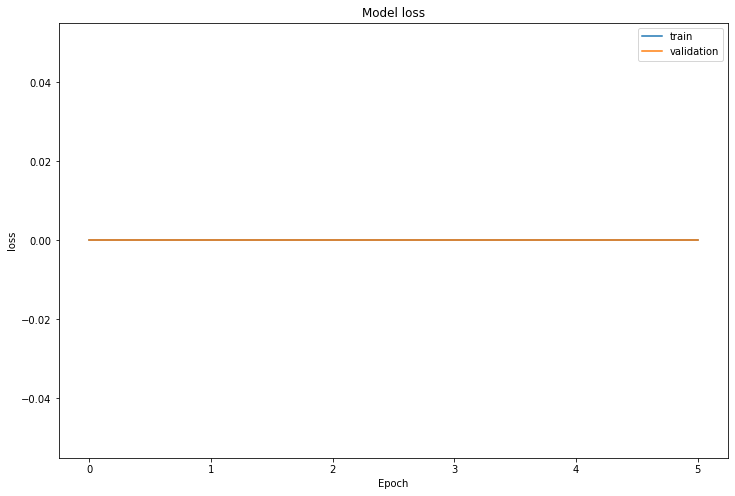

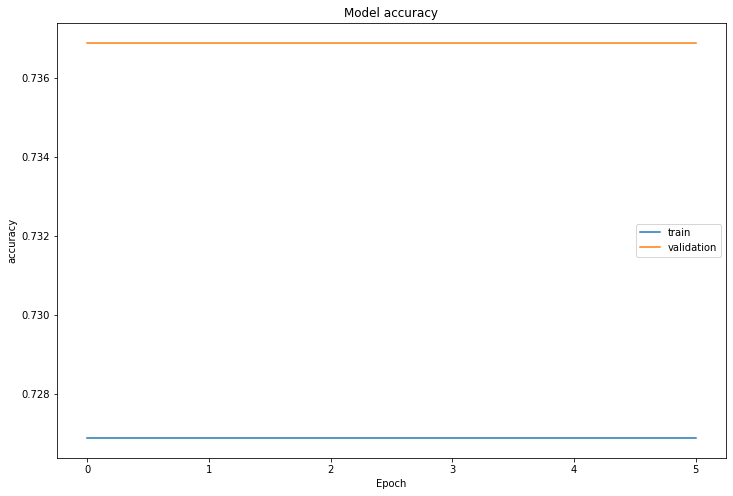

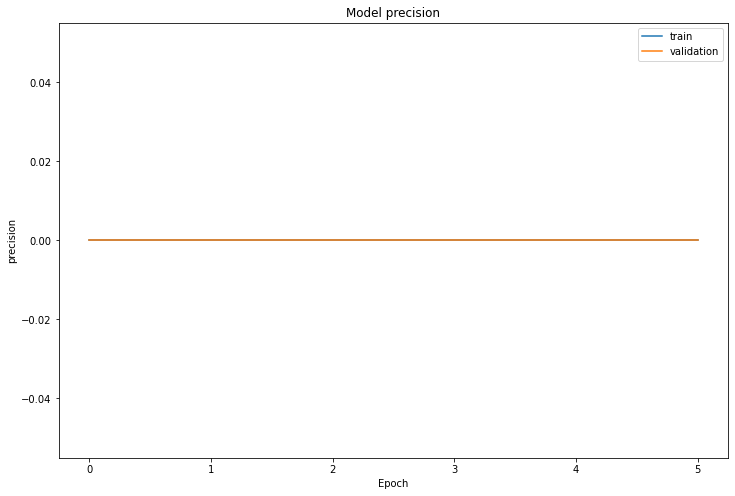

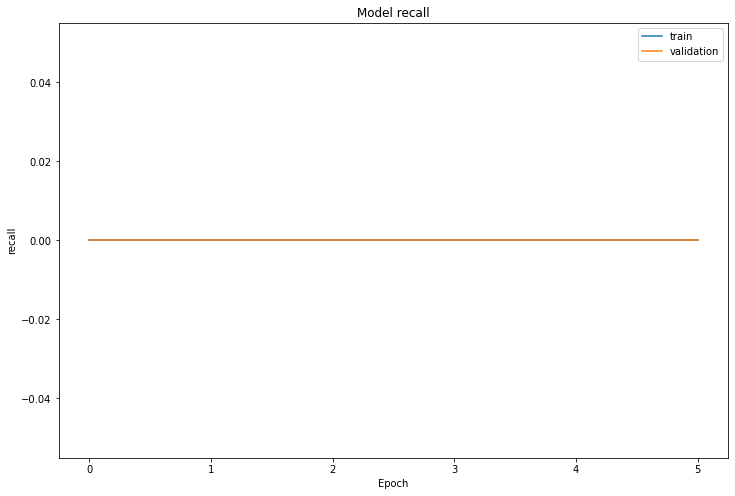

In [15]:
metrics = list(historyA.history.keys())

df = pd.DataFrame(historyA.history)

for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

# ResNet

In [16]:
def resnet_model(input_shape):
    
    input_img = tf.keras.Input(input_shape)
    
    base = tf.keras.applications.resnet50.ResNet50(input_shape = input_shape, weights = 'imagenet',
                                                   include_top = False, input_tensor = input_img)
    
    base.trainable = False
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=3072, activation='relu')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=512, activation='relu')(N2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 1, activation = 'sigmoid')(N3)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

## Transfer learning with weights pretrained on imagenet

In [17]:
checkpoint_path = 'training/conv/ResnetImgnet_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [18]:
lr = 0.00005
Resnet_model = resnet_model((224, 224, 3))
Resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
Resnet_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

In [19]:
historyRI = Resnet_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[cp_callback, estop])

Resnet_model.save('ResnetImgnet_model.h5')

Epoch 1/100
125/125 [==============================] - 19s 117ms/step - loss: 0.6670 - accuracy: 0.9252 - precision_1: 0.7921 - recall_1: 0.9843 - val_loss: 0.6668 - val_accuracy: 0.9385 - val_precision_1: 0.8125 - val_recall_1: 0.9962

Epoch 00001: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
125/125 [==============================] - 14s 109ms/step - loss: 0.6666 - accuracy: 0.9400 - precision_1: 0.8214 - recall_1: 0.9972 - val_loss: 0.6663 - val_accuracy: 0.9546 - val_precision_1: 0.8553 - val_recall_1: 0.9962

Epoch 00002: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6660 - accuracy: 0.9511 - precision_1: 0.8493 - recall_1: 0.9982 - val_loss: 0.6657 - val_accuracy: 0.9718 - val_precision_1: 0.9059 - val_recall_1: 0.9962

Epoch 00003: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
125/125 [==============================] - 16s 124ms/step - loss: 0.6654 - accuracy: 0.9602 - precision_1: 0.8740 - recall_1: 0.9982 - val_loss: 0.6651 - val_accuracy: 0.9768 - val_precision_1: 0.9220 - val_recall_1: 0.9962

Epoch 00004: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6647 - accuracy: 0.9708 - precision_1: 0.9054 - recall_1: 0.9972 - val_loss: 0.6643 - val_accuracy: 0.9829 - val_precision_1: 0.9420 - val_recall_1: 0.9962

Epoch 00005: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6639 - accuracy: 0.9773 - precision_1: 0.9248 - recall_1: 0.9982 - val_loss: 0.6635 - val_accuracy: 0.9839 - val_precision_1: 0.9455 - val_recall_1: 0.9962

Epoch 00006: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6631 - accuracy: 0.9773 - precision_1: 0.9241 - recall_1: 0.9991 - val_loss: 0.6627 - val_accuracy: 0.9869 - val_precision_1: 0.9559 - val_recall_1: 0.9962

Epoch 00007: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6623 - accuracy: 0.9798 - precision_1: 0.9343 - recall_1: 0.9963 - val_loss: 0.6619 - val_accuracy: 0.9879 - val_precision_1: 0.9594 - val_recall_1: 0.9962

Epoch 00008: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
125/125 [==============================] - 13s 103ms/step - loss: 0.6615 - accuracy: 0.9836 - precision_1: 0.9434 - recall_1: 1.0000 - val_loss: 0.6610 - val_accuracy: 0.9889 - val_precision_1: 0.9630 - val_recall_1: 0.9962

Epoch 00009: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
125/125 [==============================] - 14s 106ms/step - loss: 0.6606 - accuracy: 0.9887 - precision_1: 0.9610 - recall_1: 0.9991 - val_loss: 0.6601 - val_accuracy: 0.9879 - val_precision_1: 0.9594 - val_recall_1: 0.9962

Epoch 00010: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6597 - accuracy: 0.9892 - precision_1: 0.9635 - recall_1: 0.9982 - val_loss: 0.6592 - val_accuracy: 0.9909 - val_precision_1: 0.9701 - val_recall_1: 0.9962

Epoch 00011: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
125/125 [==============================] - 14s 106ms/step - loss: 0.6587 - accuracy: 0.9861 - precision_1: 0.9533 - recall_1: 0.9982 - val_loss: 0.6583 - val_accuracy: 0.9909 - val_precision_1: 0.9701 - val_recall_1: 0.9962

Epoch 00012: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
125/125 [==============================] - 13s 104ms/step - loss: 0.6578 - accuracy: 0.9892 - precision_1: 0.9635 - recall_1: 0.9982 - val_loss: 0.6573 - val_accuracy: 0.9929 - val_precision_1: 0.9774 - val_recall_1: 0.9962

Epoch 00013: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/100
125/125 [==============================] - 14s 106ms/step - loss: 0.6569 - accuracy: 0.9914 - precision_1: 0.9730 - recall_1: 0.9963 - val_loss: 0.6564 - val_accuracy: 0.9929 - val_precision_1: 0.9774 - val_recall_1: 0.9962

Epoch 00014: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6560 - accuracy: 0.9912 - precision_1: 0.9704 - recall_1: 0.9982 - val_loss: 0.6555 - val_accuracy: 0.9929 - val_precision_1: 0.9774 - val_recall_1: 0.9962

Epoch 00015: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/100
125/125 [==============================] - 14s 106ms/step - loss: 0.6550 - accuracy: 0.9904 - precision_1: 0.9678 - recall_1: 0.9982 - val_loss: 0.6545 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00016: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6541 - accuracy: 0.9899 - precision_1: 0.9661 - recall_1: 0.9982 - val_loss: 0.6536 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00017: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/100
125/125 [==============================] - 14s 108ms/step - loss: 0.6531 - accuracy: 0.9937 - precision_1: 0.9783 - recall_1: 0.9991 - val_loss: 0.6526 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00018: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/100
125/125 [==============================] - 15s 113ms/step - loss: 0.6521 - accuracy: 0.9965 - precision_1: 0.9881 - recall_1: 0.9991 - val_loss: 0.6516 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00019: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6511 - accuracy: 0.9937 - precision_1: 0.9775 - recall_1: 1.0000 - val_loss: 0.6506 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00020: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/100
125/125 [==============================] - 14s 103ms/step - loss: 0.6501 - accuracy: 0.9970 - precision_1: 0.9908 - recall_1: 0.9982 - val_loss: 0.6496 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00021: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6491 - accuracy: 0.9960 - precision_1: 0.9863 - recall_1: 0.9991 - val_loss: 0.6485 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00022: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/100
125/125 [==============================] - 15s 108ms/step - loss: 0.6480 - accuracy: 0.9965 - precision_1: 0.9872 - recall_1: 1.0000 - val_loss: 0.6475 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00023: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/100
125/125 [==============================] - 15s 108ms/step - loss: 0.6470 - accuracy: 0.9975 - precision_1: 0.9918 - recall_1: 0.9991 - val_loss: 0.6465 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00024: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6459 - accuracy: 0.9967 - precision_1: 0.9881 - recall_1: 1.0000 - val_loss: 0.6454 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00025: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6450 - accuracy: 0.9987 - precision_1: 0.9954 - recall_1: 1.0000 - val_loss: 0.6445 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00026: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6439 - accuracy: 0.9977 - precision_1: 0.9918 - recall_1: 1.0000 - val_loss: 0.6434 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00027: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/100
125/125 [==============================] - 14s 108ms/step - loss: 0.6430 - accuracy: 0.9967 - precision_1: 0.9881 - recall_1: 1.0000 - val_loss: 0.6425 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00028: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6420 - accuracy: 0.9957 - precision_1: 0.9846 - recall_1: 1.0000 - val_loss: 0.6415 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00029: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6410 - accuracy: 0.9975 - precision_1: 0.9927 - recall_1: 0.9982 - val_loss: 0.6405 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00030: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/100
125/125 [==============================] - 14s 110ms/step - loss: 0.6401 - accuracy: 0.9975 - precision_1: 0.9909 - recall_1: 1.0000 - val_loss: 0.6396 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00031: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/100
125/125 [==============================] - 15s 111ms/step - loss: 0.6391 - accuracy: 0.9972 - precision_1: 0.9918 - recall_1: 0.9982 - val_loss: 0.6386 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00032: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6381 - accuracy: 0.9980 - precision_1: 0.9927 - recall_1: 1.0000 - val_loss: 0.6377 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00033: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/100
125/125 [==============================] - 13s 102ms/step - loss: 0.6372 - accuracy: 0.9977 - precision_1: 0.9918 - recall_1: 1.0000 - val_loss: 0.6367 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00034: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/100
125/125 [==============================] - 14s 106ms/step - loss: 0.6362 - accuracy: 0.9982 - precision_1: 0.9954 - recall_1: 0.9982 - val_loss: 0.6358 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00035: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/100
125/125 [==============================] - 15s 115ms/step - loss: 0.6353 - accuracy: 0.9985 - precision_1: 0.9954 - recall_1: 0.9991 - val_loss: 0.6348 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00036: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/100
125/125 [==============================] - 15s 115ms/step - loss: 0.6344 - accuracy: 0.9972 - precision_1: 0.9900 - recall_1: 1.0000 - val_loss: 0.6340 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00037: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6336 - accuracy: 0.9980 - precision_1: 0.9945 - recall_1: 0.9982 - val_loss: 0.6331 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00038: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6327 - accuracy: 0.9975 - precision_1: 0.9909 - recall_1: 1.0000 - val_loss: 0.6323 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00039: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6318 - accuracy: 0.9977 - precision_1: 0.9918 - recall_1: 1.0000 - val_loss: 0.6314 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00040: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/100
125/125 [==============================] - 15s 114ms/step - loss: 0.6310 - accuracy: 0.9970 - precision_1: 0.9891 - recall_1: 1.0000 - val_loss: 0.6306 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00041: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/100
125/125 [==============================] - 15s 110ms/step - loss: 0.6303 - accuracy: 0.9970 - precision_1: 0.9891 - recall_1: 1.0000 - val_loss: 0.6299 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00042: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6296 - accuracy: 0.9987 - precision_1: 0.9963 - recall_1: 0.9991 - val_loss: 0.6292 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00043: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/100
125/125 [==============================] - 15s 112ms/step - loss: 0.6288 - accuracy: 0.9985 - precision_1: 0.9963 - recall_1: 0.9982 - val_loss: 0.6284 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00044: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 45/100
125/125 [==============================] - 15s 110ms/step - loss: 0.6280 - accuracy: 0.9995 - precision_1: 0.9982 - recall_1: 1.0000 - val_loss: 0.6276 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00045: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/100
125/125 [==============================] - 14s 109ms/step - loss: 0.6273 - accuracy: 0.9977 - precision_1: 0.9927 - recall_1: 0.9991 - val_loss: 0.6270 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00046: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 47/100
125/125 [==============================] - 15s 112ms/step - loss: 0.6267 - accuracy: 0.9987 - precision_1: 0.9954 - recall_1: 1.0000 - val_loss: 0.6263 - val_accuracy: 0.9940 - val_precision_1: 0.9811 - val_recall_1: 0.9962

Epoch 00047: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 48/100
125/125 [==============================] - 15s 109ms/step - loss: 0.6259 - accuracy: 0.9982 - precision_1: 0.9945 - recall_1: 0.9991 - val_loss: 0.6255 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00048: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 49/100
125/125 [==============================] - 15s 113ms/step - loss: 0.6251 - accuracy: 0.9995 - precision_1: 0.9982 - recall_1: 1.0000 - val_loss: 0.6247 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00049: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/100
125/125 [==============================] - 15s 111ms/step - loss: 0.6244 - accuracy: 0.9992 - precision_1: 0.9972 - recall_1: 1.0000 - val_loss: 0.6240 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00050: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 51/100
125/125 [==============================] - 15s 110ms/step - loss: 0.6237 - accuracy: 0.9980 - precision_1: 0.9936 - recall_1: 0.9991 - val_loss: 0.6234 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00051: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 52/100
125/125 [==============================] - 15s 113ms/step - loss: 0.6231 - accuracy: 0.9995 - precision_1: 0.9991 - recall_1: 0.9991 - val_loss: 0.6227 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00052: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 53/100
125/125 [==============================] - 15s 112ms/step - loss: 0.6223 - accuracy: 0.9982 - precision_1: 0.9945 - recall_1: 0.9991 - val_loss: 0.6220 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00053: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 54/100
125/125 [==============================] - 14s 108ms/step - loss: 0.6219 - accuracy: 0.9965 - precision_1: 0.9872 - recall_1: 1.0000 - val_loss: 0.6216 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00054: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 55/100
125/125 [==============================] - 15s 112ms/step - loss: 0.6213 - accuracy: 0.9982 - precision_1: 0.9936 - recall_1: 1.0000 - val_loss: 0.6210 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00055: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 56/100
125/125 [==============================] - 14s 109ms/step - loss: 0.6207 - accuracy: 0.9990 - precision_1: 0.9991 - recall_1: 0.9972 - val_loss: 0.6203 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00056: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 57/100
125/125 [==============================] - 15s 112ms/step - loss: 0.6200 - accuracy: 0.9987 - precision_1: 0.9954 - recall_1: 1.0000 - val_loss: 0.6197 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00057: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 58/100
125/125 [==============================] - 15s 111ms/step - loss: 0.6195 - accuracy: 0.9975 - precision_1: 0.9918 - recall_1: 0.9991 - val_loss: 0.6192 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00058: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 59/100
125/125 [==============================] - 16s 117ms/step - loss: 0.6190 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6186 - val_accuracy: 0.9950 - val_precision_1: 0.9848 - val_recall_1: 0.9962

Epoch 00059: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 60/100
125/125 [==============================] - 15s 110ms/step - loss: 0.6183 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6179 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00060: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 61/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6176 - accuracy: 0.9985 - precision_1: 0.9972 - recall_1: 0.9972 - val_loss: 0.6173 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00061: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 62/100
125/125 [==============================] - 14s 109ms/step - loss: 0.6171 - accuracy: 0.9987 - precision_1: 0.9963 - recall_1: 0.9991 - val_loss: 0.6168 - val_accuracy: 0.9970 - val_precision_1: 0.9924 - val_recall_1: 0.9962

Epoch 00062: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 63/100
125/125 [==============================] - 16s 117ms/step - loss: 0.6165 - accuracy: 0.9997 - precision_1: 1.0000 - recall_1: 0.9991 - val_loss: 0.6162 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00063: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 64/100
125/125 [==============================] - 15s 115ms/step - loss: 0.6159 - accuracy: 0.9992 - precision_1: 0.9982 - recall_1: 0.9991 - val_loss: 0.6156 - val_accuracy: 0.9970 - val_precision_1: 0.9924 - val_recall_1: 0.9962

Epoch 00064: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 65/100
125/125 [==============================] - 15s 115ms/step - loss: 0.6153 - accuracy: 0.9990 - precision_1: 0.9972 - recall_1: 0.9991 - val_loss: 0.6150 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00065: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 66/100
125/125 [==============================] - 16s 120ms/step - loss: 0.6147 - accuracy: 0.9995 - precision_1: 1.0000 - recall_1: 0.9982 - val_loss: 0.6144 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00066: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 67/100
125/125 [==============================] - 15s 114ms/step - loss: 0.6142 - accuracy: 0.9992 - precision_1: 0.9972 - recall_1: 1.0000 - val_loss: 0.6139 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00067: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 68/100
125/125 [==============================] - 15s 110ms/step - loss: 0.6136 - accuracy: 0.9987 - precision_1: 0.9954 - recall_1: 1.0000 - val_loss: 0.6134 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00068: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 69/100
125/125 [==============================] - 16s 118ms/step - loss: 0.6132 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6128 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00069: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 70/100
125/125 [==============================] - 16s 120ms/step - loss: 0.6125 - accuracy: 0.9995 - precision_1: 0.9991 - recall_1: 0.9991 - val_loss: 0.6122 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00070: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 71/100
125/125 [==============================] - 15s 115ms/step - loss: 0.6120 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6116 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00071: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 72/100
125/125 [==============================] - 16s 117ms/step - loss: 0.6114 - accuracy: 0.9995 - precision_1: 0.9982 - recall_1: 1.0000 - val_loss: 0.6111 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00072: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 73/100
125/125 [==============================] - 16s 122ms/step - loss: 0.6108 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6104 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00073: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 74/100
125/125 [==============================] - 16s 119ms/step - loss: 0.6101 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6098 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00074: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 75/100
125/125 [==============================] - 16s 120ms/step - loss: 0.6096 - accuracy: 0.9985 - precision_1: 0.9963 - recall_1: 0.9982 - val_loss: 0.6094 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00075: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 76/100
125/125 [==============================] - 16s 122ms/step - loss: 0.6091 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6089 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00076: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 77/100
125/125 [==============================] - 16s 122ms/step - loss: 0.6086 - accuracy: 0.9995 - precision_1: 0.9982 - recall_1: 1.0000 - val_loss: 0.6084 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00077: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 78/100
125/125 [==============================] - 17s 128ms/step - loss: 0.6081 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6078 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00078: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 79/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6076 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6073 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00079: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 80/100
125/125 [==============================] - 14s 105ms/step - loss: 0.6071 - accuracy: 0.9997 - precision_1: 1.0000 - recall_1: 0.9991 - val_loss: 0.6068 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00080: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 81/100
125/125 [==============================] - 14s 106ms/step - loss: 0.6065 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6062 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00081: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 82/100
125/125 [==============================] - 15s 109ms/step - loss: 0.6061 - accuracy: 0.9982 - precision_1: 0.9945 - recall_1: 0.9991 - val_loss: 0.6059 - val_accuracy: 0.9970 - val_precision_1: 0.9924 - val_recall_1: 0.9962

Epoch 00082: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 83/100
125/125 [==============================] - 13s 103ms/step - loss: 0.6056 - accuracy: 0.9997 - precision_1: 1.0000 - recall_1: 0.9991 - val_loss: 0.6053 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00083: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 84/100
125/125 [==============================] - 14s 107ms/step - loss: 0.6050 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6047 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00084: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 85/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6045 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6042 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00085: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 86/100
125/125 [==============================] - 15s 109ms/step - loss: 0.6041 - accuracy: 0.9975 - precision_1: 0.9954 - recall_1: 0.9954 - val_loss: 0.6040 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00086: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 87/100
125/125 [==============================] - 17s 130ms/step - loss: 0.6037 - accuracy: 0.9997 - precision_1: 1.0000 - recall_1: 0.9991 - val_loss: 0.6035 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00087: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 88/100
125/125 [==============================] - 16s 119ms/step - loss: 0.6032 - accuracy: 0.9997 - precision_1: 0.9991 - recall_1: 1.0000 - val_loss: 0.6030 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00088: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 89/100
125/125 [==============================] - 17s 129ms/step - loss: 0.6028 - accuracy: 0.9990 - precision_1: 0.9972 - recall_1: 0.9991 - val_loss: 0.6027 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00089: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 90/100
125/125 [==============================] - 16s 122ms/step - loss: 0.6025 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6022 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00090: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 91/100
125/125 [==============================] - 17s 129ms/step - loss: 0.6020 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.6018 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00091: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 92/100
125/125 [==============================] - 16s 124ms/step - loss: 0.6017 - accuracy: 0.9982 - precision_1: 0.9936 - recall_1: 1.0000 - val_loss: 0.6016 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00092: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 93/100
125/125 [==============================] - 14s 108ms/step - loss: 0.6014 - accuracy: 0.9992 - precision_1: 0.9972 - recall_1: 1.0000 - val_loss: 0.6012 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00093: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 94/100
125/125 [==============================] - 15s 115ms/step - loss: 0.6010 - accuracy: 0.9992 - precision_1: 0.9991 - recall_1: 0.9982 - val_loss: 0.6009 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00094: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 95/100
125/125 [==============================] - 14s 104ms/step - loss: 0.6007 - accuracy: 0.9987 - precision_1: 0.9982 - recall_1: 0.9972 - val_loss: 0.6005 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00095: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 96/100
125/125 [==============================] - 15s 111ms/step - loss: 0.6003 - accuracy: 0.9992 - precision_1: 0.9982 - recall_1: 0.9991 - val_loss: 0.6002 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00096: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 97/100
125/125 [==============================] - 13s 103ms/step - loss: 0.6000 - accuracy: 0.9995 - precision_1: 1.0000 - recall_1: 0.9982 - val_loss: 0.5999 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00097: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 98/100
125/125 [==============================] - 14s 108ms/step - loss: 0.5997 - accuracy: 0.9995 - precision_1: 0.9991 - recall_1: 0.9991 - val_loss: 0.5995 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00098: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 99/100
125/125 [==============================] - 14s 107ms/step - loss: 0.5993 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.5991 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00099: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 100/100
125/125 [==============================] - 14s 109ms/step - loss: 0.5988 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 0.5986 - val_accuracy: 0.9960 - val_precision_1: 0.9886 - val_recall_1: 0.9962

Epoch 00100: saving model to training/conv/ResnetImgnet_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1']) 8 <class 'dict_keys'>


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.p

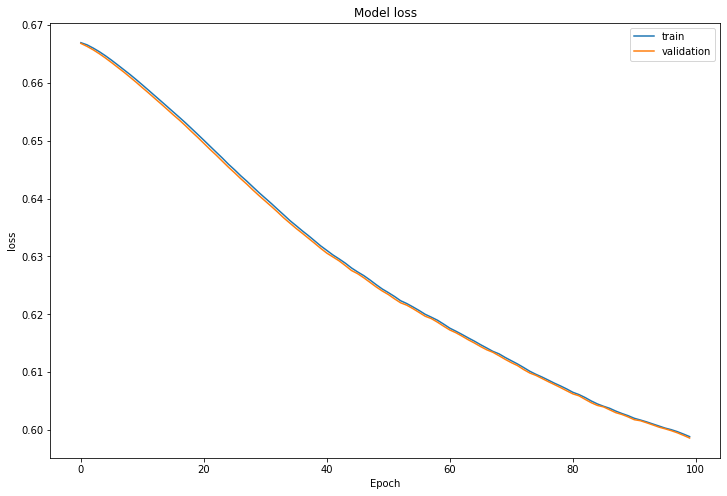

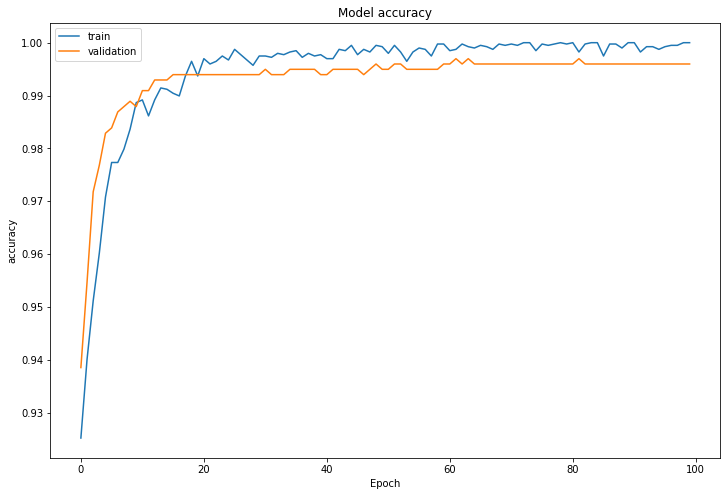

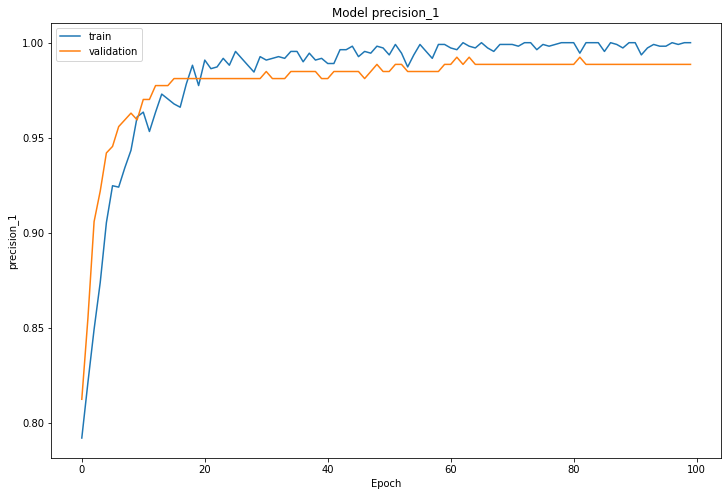

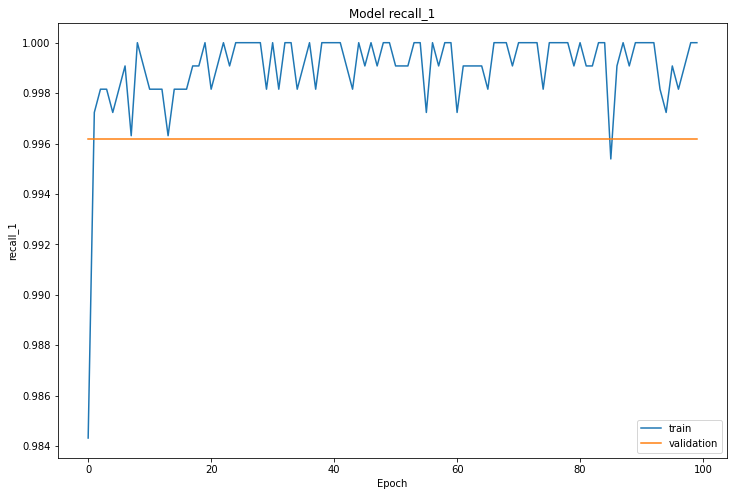

In [20]:
l = historyRI.history.keys()
print(l, len(l), type(l))
metrics = list(historyRI.history.keys())

df = pd.DataFrame(historyRI.history)

for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

# VGG16

In [21]:
def vgg_model(input_shape, weights='imagenet',transfer=True):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    base = tf.keras.applications.VGG16(input_shape = input_shape, weights = weights,
                                       include_top = False, input_tensor = input_img)
    base.trainable = not(transfer)
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 256, activation = 'ReLU')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 128, activation = 'ReLU')(A2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 1, activation = 'sigmoid')(N3)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

## Transfer Learning with weights pretrained on *imagenet*

In [22]:
vggnet_I = vgg_model(input_shape=(224,224,3), weights='imagenet',transfer=True)
lr = 0.00005
vggnet_I.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
vggnet_I.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [23]:
checkpoint_path = 'training/conv/VGG16Imgnet_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [24]:
historyVI = vggnet_I.fit(train_ds, 
                          epochs=100, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback, estop])
vggnet_I.save('VGG16_imagenet_model.h5')

Epoch 1/100
125/125 [==============================] - 19s 110ms/step - loss: 0.1023 - accuracy: 0.7405 - precision_2: 0.5152 - recall_2: 0.8441 - val_loss: 0.1023 - val_accuracy: 0.8649 - val_precision_2: 0.6608 - val_recall_2: 1.0000

Epoch 00001: saving model to training/conv/VGG16Imgnet_cp.ckpt
Epoch 2/100
125/125 [==============================] - 14s 106ms/step - loss: 0.1023 - accuracy: 0.9257 - precision_2: 0.7916 - recall_2: 0.9880 - val_loss: 0.1022 - val_accuracy: 0.9476 - val_precision_2: 0.8360 - val_recall_2: 0.9962

Epoch 00002: saving model to training/conv/VGG16Imgnet_cp.ckpt
Epoch 3/100
125/125 [==============================] - 17s 127ms/step - loss: 0.1022 - accuracy: 0.9506 - precision_2: 0.8507 - recall_2: 0.9935 - val_loss: 0.1022 - val_accuracy: 0.9647 - val_precision_2: 0.8844 - val_recall_2: 0.9962

Epoch 00003: saving model to training/conv/VGG16Imgnet_cp.ckpt
Epoch 4/100
125/125 [==============================] - 14s 108ms/step - loss: 0.1021 - accuracy: 0.9

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2']) 8 <class 'dict_keys'>


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.p

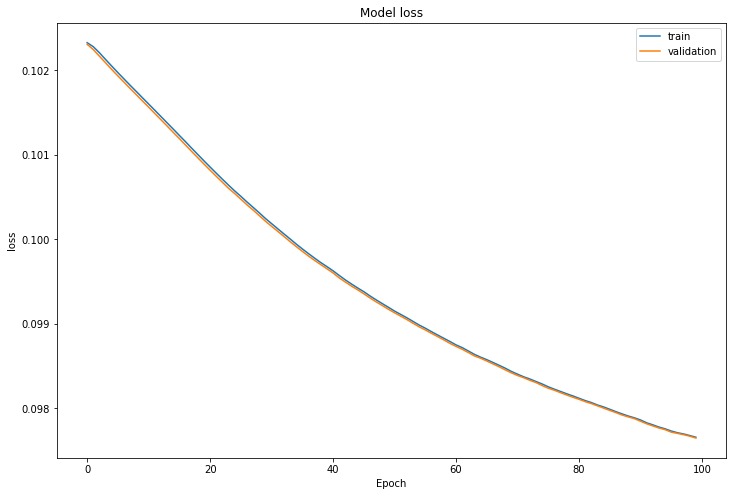

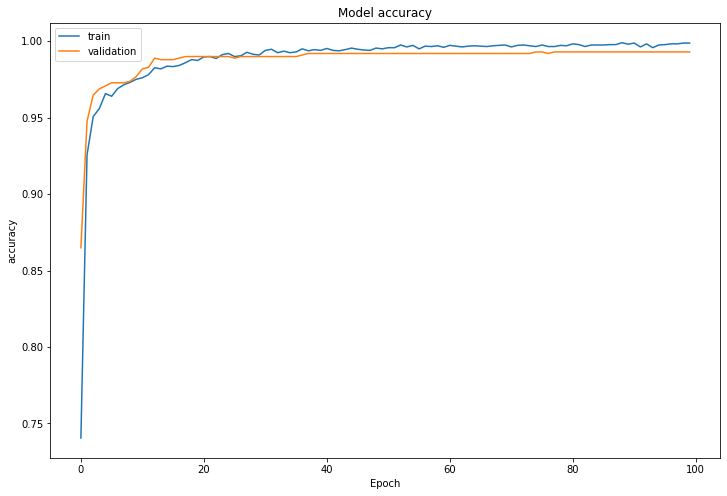

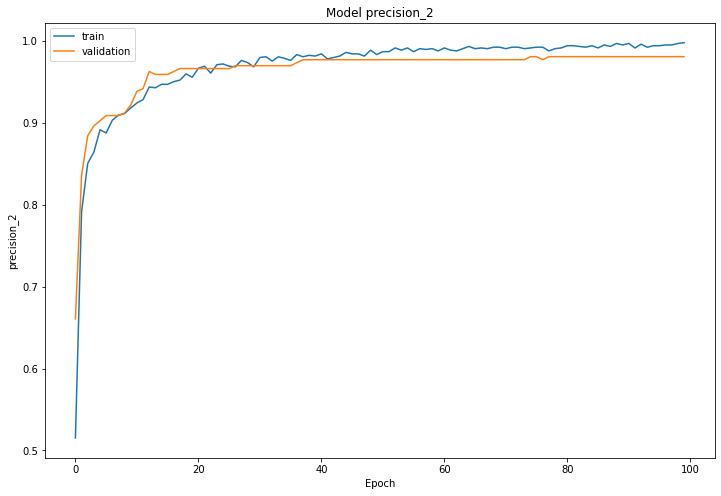

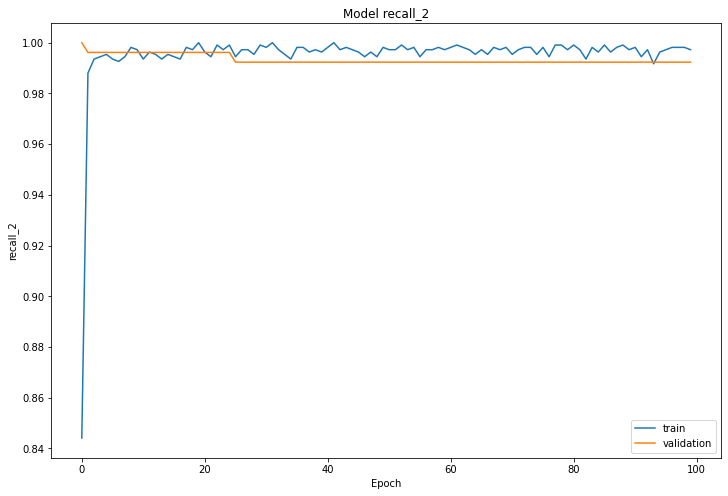

In [25]:
l = historyVI.history.keys()
print(l, len(l), type(l))
metrics = list(historyVI.history.keys())

df = pd.DataFrame(historyVI.history)

for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

# Inception/GoogLeNet

[Implementation of GoogLeNet on Keras](https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c)

In [26]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [27]:

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [28]:

def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  #X = Dense(1000, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, X, name = 'GoogLeNet')

  return model

In [29]:
def build_inception():
    
    base = GoogLeNet()
    
    A0 = base.output
    
    N1 = layer.BatchNormalization()(A0)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=3072, activation='relu')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units=512, activation='relu')(N2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 1, activation = 'sigmoid')(N3)
    
    model = tf.keras.Model(inputs = base.input, outputs = outputs)
    
    return model    

In [30]:
lr = 0.00005
Inc_model = build_inception()
Inc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
Inc_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 109, 109, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 54, 54, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 54, 54, 64)   4160        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [31]:
checkpoint_path = 'training/conv/InceptionNet.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [32]:
historyInc = Inc_model.fit(train_ds, 
                           epochs=100, 
                           validation_data=val_ds, 
                           callbacks = [cp_callback, estop])
Inc_model.save('InceptionNet_model.h5')

Epoch 1/100
125/125 [==============================] - 20s 123ms/step - loss: 0.4751 - accuracy: 0.7664 - precision_3: 0.5465 - recall_3: 0.8515 - val_loss: 0.4698 - val_accuracy: 0.9758 - val_precision_3: 0.9837 - val_recall_3: 0.9234

Epoch 00001: saving model to training/conv/InceptionNet.ckpt
Epoch 2/100
125/125 [==============================] - 14s 111ms/step - loss: 0.4668 - accuracy: 0.9468 - precision_3: 0.8473 - recall_3: 0.9825 - val_loss: 0.4644 - val_accuracy: 0.9738 - val_precision_3: 0.9434 - val_recall_3: 0.9579

Epoch 00002: saving model to training/conv/InceptionNet.ckpt
Epoch 3/100
125/125 [==============================] - 14s 110ms/step - loss: 0.4629 - accuracy: 0.9579 - precision_3: 0.8805 - recall_3: 0.9788 - val_loss: 0.4616 - val_accuracy: 0.8810 - val_precision_3: 0.6907 - val_recall_3: 0.9923

Epoch 00003: saving model to training/conv/InceptionNet.ckpt
Epoch 4/100
125/125 [==============================] - 20s 159ms/step - loss: 0.4608 - accuracy: 0.9748 - 

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3']) 8 <class 'dict_keys'>


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.p

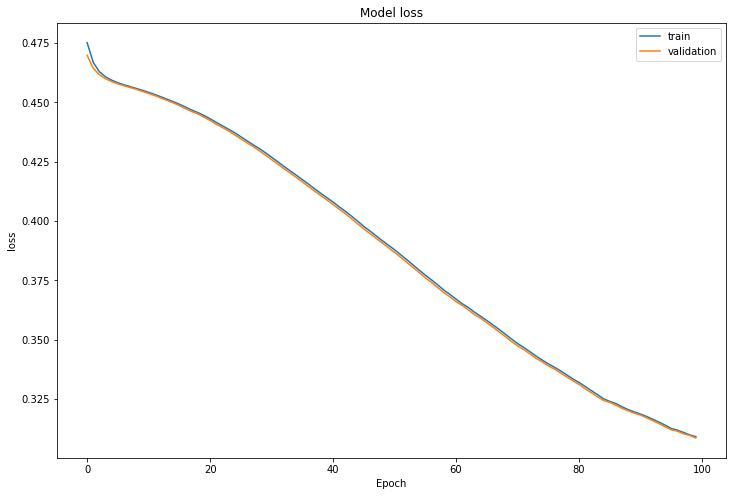

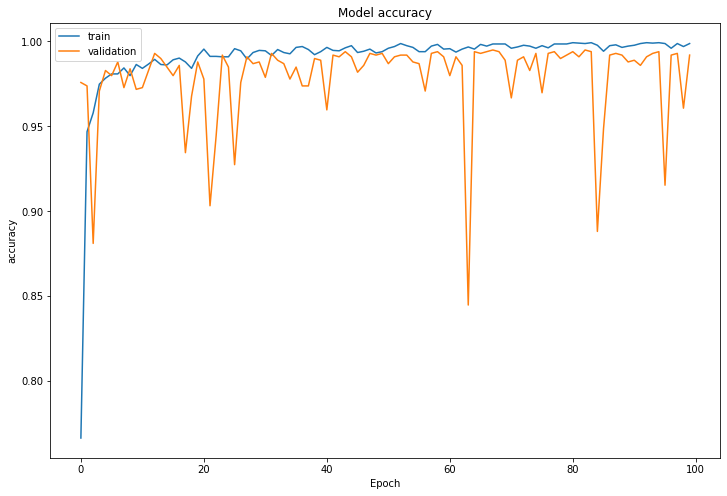

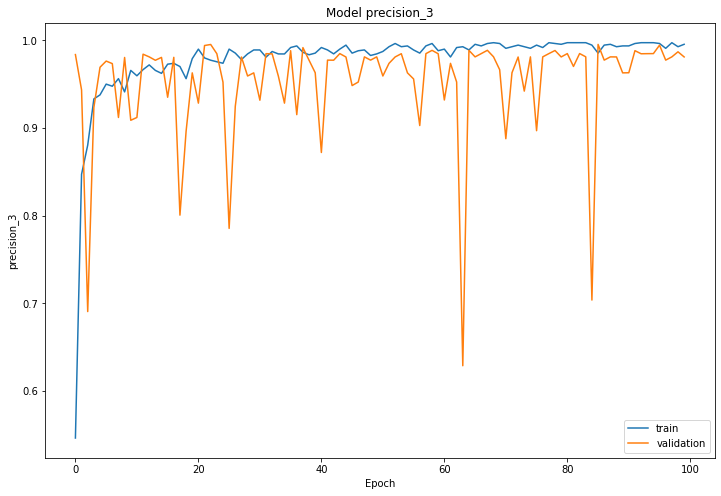

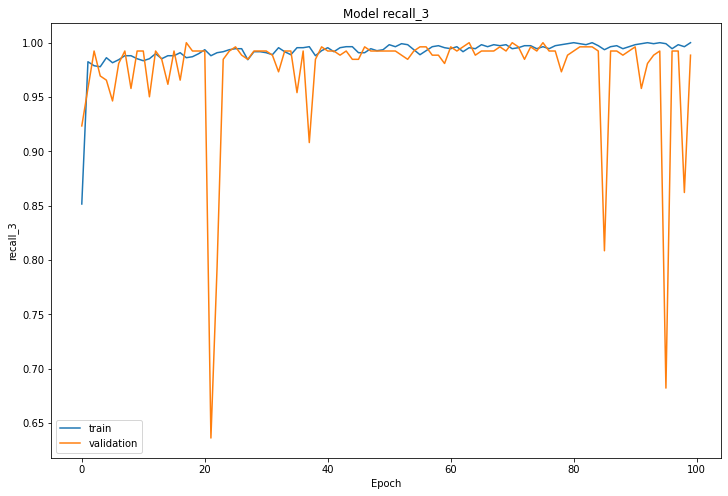

In [33]:
l = historyInc.history.keys()
print(l, len(l), type(l))
metrics = list(historyInc.history.keys())

df = pd.DataFrame(historyInc.history)

for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

# MobileNetV2

In [34]:
def Mobilenet_model(input_shape, weights=None, transfer=False):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    base = tf.keras.applications.MobileNetV2(input_shape = input_shape, weights = weights, 
                                             include_top = False, input_tensor = input_img)
    base.trainable = not(transfer)
    
    A0 = base.output
    
    A1 = layer.GlobalAveragePooling2D( )(A0)
    N1 = layer.BatchNormalization()(A1)
    N1 = layer.Dropout(0.1)(N1)
    
    A2 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 256, activation = 'ReLU')(N1)
    N2 = layer.BatchNormalization()(A2)
    N2 = layer.Dropout(0.2)(N2)
    
    A3 = layer.Dense(kernel_regularizer=tf.keras.regularizers.L2(0.0002),
                     units = 128, activation = 'ReLU')(A2)
    N3 = layer.BatchNormalization()(A3)
    N3 = layer.Dropout(0.4)(N3)
    
    outputs = layer.Dense(units = 1, activation = 'sigmoid')(N3)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    
    return model

## Transfer Learning with weights pretrained on *imagenet*

In [35]:
mobile_I = Mobilenet_model(input_shape=(224,224,3), weights='imagenet',transfer=True)

lr = 0.00005
mobile_I.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
                 
mobile_I.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_____________________________

In [36]:
checkpoint_path = 'training/conv/Mobile_image_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

estop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                         min_delta=0.0001,
                                         patience=5,
                                         mode="min",
                                         restore_best_weights=True)

In [37]:
historyMi = mobile_I.fit(train_ds, 
                          epochs=100, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback, estop])
mobile_I.save('Mobile_image_model.h5')

Epoch 1/100
125/125 [==============================] - 16s 101ms/step - loss: 0.1197 - accuracy: 0.7763 - precision_4: 0.5598 - recall_4: 0.8469 - val_loss: 0.1196 - val_accuracy: 0.9022 - val_precision_4: 0.7470 - val_recall_4: 0.9502

Epoch 00001: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
125/125 [==============================] - 12s 92ms/step - loss: 0.1196 - accuracy: 0.8977 - precision_4: 0.7460 - recall_4: 0.9483 - val_loss: 0.1195 - val_accuracy: 0.9274 - val_precision_4: 0.7962 - val_recall_4: 0.9732

Epoch 00002: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
125/125 [==============================] - 13s 98ms/step - loss: 0.1195 - accuracy: 0.9166 - precision_4: 0.7766 - recall_4: 0.9751 - val_loss: 0.1194 - val_accuracy: 0.9335 - val_precision_4: 0.8115 - val_recall_4: 0.9732

Epoch 00003: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
125/125 [==============================] - 19s 148ms/step - loss: 0.1194 - accuracy: 0.9216 - precision_4: 0.7852 - recall_4: 0.9815 - val_loss: 0.1194 - val_accuracy: 0.9466 - val_precision_4: 0.8421 - val_recall_4: 0.9808

Epoch 00004: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
125/125 [==============================] - 12s 92ms/step - loss: 0.1193 - accuracy: 0.9264 - precision_4: 0.7946 - recall_4: 0.9852 - val_loss: 0.1193 - val_accuracy: 0.9486 - val_precision_4: 0.8477 - val_recall_4: 0.9808

Epoch 00005: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
125/125 [==============================] - 12s 96ms/step - loss: 0.1193 - accuracy: 0.9355 - precision_4: 0.8151 - recall_4: 0.9880 - val_loss: 0.1192 - val_accuracy: 0.9506 - val_precision_4: 0.8533 - val_recall_4: 0.9808

Epoch 00006: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
125/125 [==============================] - 12s 94ms/step - loss: 0.1192 - accuracy: 0.9410 - precision_4: 0.8289 - recall_4: 0.9880 - val_loss: 0.1192 - val_accuracy: 0.9617 - val_precision_4: 0.8832 - val_recall_4: 0.9847

Epoch 00007: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
125/125 [==============================] - 17s 129ms/step - loss: 0.1191 - accuracy: 0.9418 - precision_4: 0.8319 - recall_4: 0.9862 - val_loss: 0.1191 - val_accuracy: 0.9667 - val_precision_4: 0.8986 - val_recall_4: 0.9847

Epoch 00008: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
125/125 [==============================] - 13s 97ms/step - loss: 0.1191 - accuracy: 0.9521 - precision_4: 0.8565 - recall_4: 0.9908 - val_loss: 0.1190 - val_accuracy: 0.9698 - val_precision_4: 0.9081 - val_recall_4: 0.9847

Epoch 00009: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
125/125 [==============================] - 13s 99ms/step - loss: 0.1190 - accuracy: 0.9572 - precision_4: 0.8715 - recall_4: 0.9889 - val_loss: 0.1190 - val_accuracy: 0.9718 - val_precision_4: 0.9206 - val_recall_4: 0.9770

Epoch 00010: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
125/125 [==============================] - 12s 94ms/step - loss: 0.1190 - accuracy: 0.9584 - precision_4: 0.8776 - recall_4: 0.9852 - val_loss: 0.1189 - val_accuracy: 0.9728 - val_precision_4: 0.9209 - val_recall_4: 0.9808

Epoch 00011: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
125/125 [==============================] - 16s 119ms/step - loss: 0.1189 - accuracy: 0.9620 - precision_4: 0.8846 - recall_4: 0.9899 - val_loss: 0.1189 - val_accuracy: 0.9708 - val_precision_4: 0.9143 - val_recall_4: 0.9808

Epoch 00012: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
125/125 [==============================] - 12s 93ms/step - loss: 0.1189 - accuracy: 0.9602 - precision_4: 0.8795 - recall_4: 0.9899 - val_loss: 0.1188 - val_accuracy: 0.9738 - val_precision_4: 0.9242 - val_recall_4: 0.9808

Epoch 00013: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/100
125/125 [==============================] - 12s 93ms/step - loss: 0.1188 - accuracy: 0.9637 - precision_4: 0.8904 - recall_4: 0.9889 - val_loss: 0.1188 - val_accuracy: 0.9738 - val_precision_4: 0.9242 - val_recall_4: 0.9808

Epoch 00014: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/100
125/125 [==============================] - 13s 98ms/step - loss: 0.1188 - accuracy: 0.9718 - precision_4: 0.9140 - recall_4: 0.9899 - val_loss: 0.1187 - val_accuracy: 0.9758 - val_precision_4: 0.9309 - val_recall_4: 0.9808

Epoch 00015: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/100
125/125 [==============================] - 19s 147ms/step - loss: 0.1187 - accuracy: 0.9730 - precision_4: 0.9193 - recall_4: 0.9880 - val_loss: 0.1187 - val_accuracy: 0.9768 - val_precision_4: 0.9343 - val_recall_4: 0.9808

Epoch 00016: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/100
125/125 [==============================] - 12s 94ms/step - loss: 0.1187 - accuracy: 0.9708 - precision_4: 0.9123 - recall_4: 0.9880 - val_loss: 0.1186 - val_accuracy: 0.9768 - val_precision_4: 0.9343 - val_recall_4: 0.9808

Epoch 00017: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/100
125/125 [==============================] - 12s 92ms/step - loss: 0.1186 - accuracy: 0.9718 - precision_4: 0.9211 - recall_4: 0.9806 - val_loss: 0.1186 - val_accuracy: 0.9829 - val_precision_4: 0.9552 - val_recall_4: 0.9808

Epoch 00018: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/100
125/125 [==============================] - 12s 93ms/step - loss: 0.1186 - accuracy: 0.9783 - precision_4: 0.9324 - recall_4: 0.9926 - val_loss: 0.1186 - val_accuracy: 0.9788 - val_precision_4: 0.9412 - val_recall_4: 0.9808

Epoch 00019: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/100
125/125 [==============================] - 19s 143ms/step - loss: 0.1185 - accuracy: 0.9786 - precision_4: 0.9347 - recall_4: 0.9908 - val_loss: 0.1185 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00020: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/100
125/125 [==============================] - 13s 97ms/step - loss: 0.1185 - accuracy: 0.9809 - precision_4: 0.9413 - recall_4: 0.9917 - val_loss: 0.1185 - val_accuracy: 0.9839 - val_precision_4: 0.9588 - val_recall_4: 0.9808

Epoch 00021: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/100
125/125 [==============================] - 13s 98ms/step - loss: 0.1185 - accuracy: 0.9796 - precision_4: 0.9380 - recall_4: 0.9908 - val_loss: 0.1184 - val_accuracy: 0.9819 - val_precision_4: 0.9517 - val_recall_4: 0.9808

Epoch 00022: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/100
125/125 [==============================] - 12s 93ms/step - loss: 0.1184 - accuracy: 0.9811 - precision_4: 0.9437 - recall_4: 0.9899 - val_loss: 0.1184 - val_accuracy: 0.9839 - val_precision_4: 0.9588 - val_recall_4: 0.9808

Epoch 00023: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/100
125/125 [==============================] - 19s 141ms/step - loss: 0.1184 - accuracy: 0.9824 - precision_4: 0.9479 - recall_4: 0.9899 - val_loss: 0.1184 - val_accuracy: 0.9849 - val_precision_4: 0.9590 - val_recall_4: 0.9847

Epoch 00024: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/100
125/125 [==============================] - 13s 96ms/step - loss: 0.1183 - accuracy: 0.9849 - precision_4: 0.9555 - recall_4: 0.9908 - val_loss: 0.1183 - val_accuracy: 0.9829 - val_precision_4: 0.9552 - val_recall_4: 0.9808

Epoch 00025: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/100
125/125 [==============================] - 13s 97ms/step - loss: 0.1183 - accuracy: 0.9849 - precision_4: 0.9571 - recall_4: 0.9889 - val_loss: 0.1183 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00026: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/100
125/125 [==============================] - 17s 132ms/step - loss: 0.1183 - accuracy: 0.9854 - precision_4: 0.9572 - recall_4: 0.9908 - val_loss: 0.1182 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00027: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/100
125/125 [==============================] - 12s 93ms/step - loss: 0.1182 - accuracy: 0.9829 - precision_4: 0.9488 - recall_4: 0.9908 - val_loss: 0.1182 - val_accuracy: 0.9859 - val_precision_4: 0.9625 - val_recall_4: 0.9847

Epoch 00028: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/100
125/125 [==============================] - 12s 93ms/step - loss: 0.1182 - accuracy: 0.9854 - precision_4: 0.9572 - recall_4: 0.9908 - val_loss: 0.1182 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00029: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/100
125/125 [==============================] - 12s 94ms/step - loss: 0.1182 - accuracy: 0.9874 - precision_4: 0.9608 - recall_4: 0.9945 - val_loss: 0.1181 - val_accuracy: 0.9839 - val_precision_4: 0.9623 - val_recall_4: 0.9770

Epoch 00030: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/100
125/125 [==============================] - 19s 147ms/step - loss: 0.1181 - accuracy: 0.9899 - precision_4: 0.9652 - recall_4: 0.9991 - val_loss: 0.1181 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00031: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/100
125/125 [==============================] - 13s 99ms/step - loss: 0.1181 - accuracy: 0.9874 - precision_4: 0.9616 - recall_4: 0.9935 - val_loss: 0.1181 - val_accuracy: 0.9839 - val_precision_4: 0.9623 - val_recall_4: 0.9770

Epoch 00032: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/100
125/125 [==============================] - 13s 99ms/step - loss: 0.1181 - accuracy: 0.9882 - precision_4: 0.9642 - recall_4: 0.9935 - val_loss: 0.1180 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00033: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/100
125/125 [==============================] - 12s 95ms/step - loss: 0.1180 - accuracy: 0.9851 - precision_4: 0.9588 - recall_4: 0.9880 - val_loss: 0.1180 - val_accuracy: 0.9839 - val_precision_4: 0.9623 - val_recall_4: 0.9770

Epoch 00034: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/100
125/125 [==============================] - 19s 145ms/step - loss: 0.1180 - accuracy: 0.9887 - precision_4: 0.9676 - recall_4: 0.9917 - val_loss: 0.1180 - val_accuracy: 0.9839 - val_precision_4: 0.9588 - val_recall_4: 0.9808

Epoch 00035: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/100
125/125 [==============================] - 12s 95ms/step - loss: 0.1180 - accuracy: 0.9884 - precision_4: 0.9667 - recall_4: 0.9917 - val_loss: 0.1180 - val_accuracy: 0.9859 - val_precision_4: 0.9660 - val_recall_4: 0.9808

Epoch 00036: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/100
125/125 [==============================] - 15s 113ms/step - loss: 0.1180 - accuracy: 0.9879 - precision_4: 0.9650 - recall_4: 0.9917 - val_loss: 0.1179 - val_accuracy: 0.9849 - val_precision_4: 0.9659 - val_recall_4: 0.9770

Epoch 00037: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/100
125/125 [==============================] - 13s 102ms/step - loss: 0.1179 - accuracy: 0.9877 - precision_4: 0.9608 - recall_4: 0.9954 - val_loss: 0.1179 - val_accuracy: 0.9849 - val_precision_4: 0.9624 - val_recall_4: 0.9808

Epoch 00038: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/100
125/125 [==============================] - 19s 147ms/step - loss: 0.1179 - accuracy: 0.9877 - precision_4: 0.9666 - recall_4: 0.9889 - val_loss: 0.1179 - val_accuracy: 0.9859 - val_precision_4: 0.9660 - val_recall_4: 0.9808

Epoch 00039: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/100
125/125 [==============================] - 12s 94ms/step - loss: 0.1179 - accuracy: 0.9894 - precision_4: 0.9694 - recall_4: 0.9926 - val_loss: 0.1179 - val_accuracy: 0.9859 - val_precision_4: 0.9660 - val_recall_4: 0.9808

Epoch 00040: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/100
125/125 [==============================] - 13s 95ms/step - loss: 0.1179 - accuracy: 0.9872 - precision_4: 0.9657 - recall_4: 0.9880 - val_loss: 0.1179 - val_accuracy: 0.9859 - val_precision_4: 0.9660 - val_recall_4: 0.9808

Epoch 00041: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/100
125/125 [==============================] - 12s 94ms/step - loss: 0.1179 - accuracy: 0.9894 - precision_4: 0.9736 - recall_4: 0.9880 - val_loss: 0.1178 - val_accuracy: 0.9879 - val_precision_4: 0.9770 - val_recall_4: 0.9770

Epoch 00042: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/100
125/125 [==============================] - 19s 147ms/step - loss: 0.1178 - accuracy: 0.9899 - precision_4: 0.9754 - recall_4: 0.9880 - val_loss: 0.1178 - val_accuracy: 0.9859 - val_precision_4: 0.9696 - val_recall_4: 0.9770

Epoch 00043: saving model to training/conv/Mobile_image_cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4']) 8 <class 'dict_keys'>


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.p

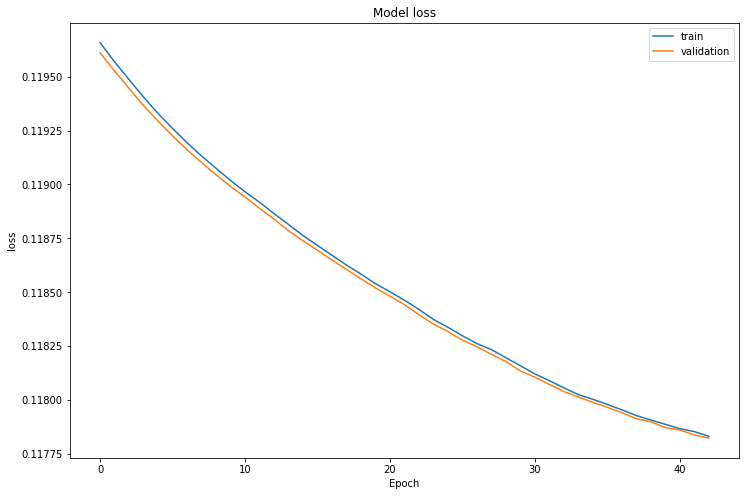

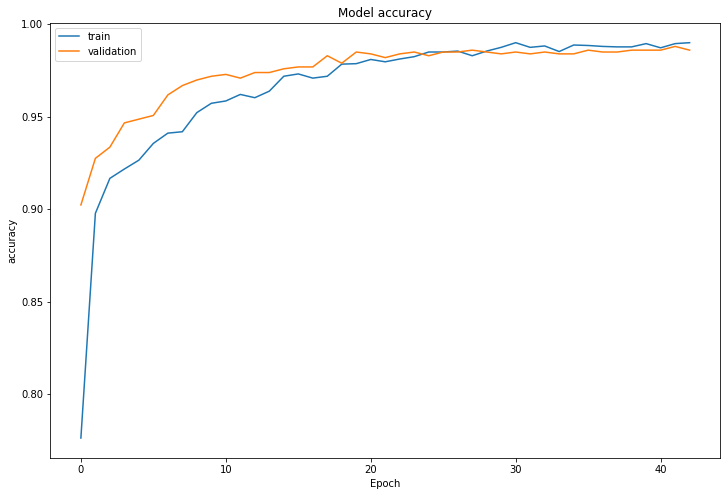

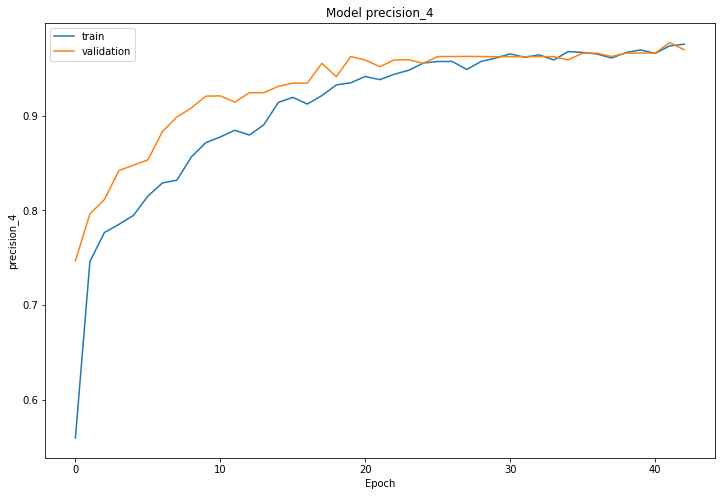

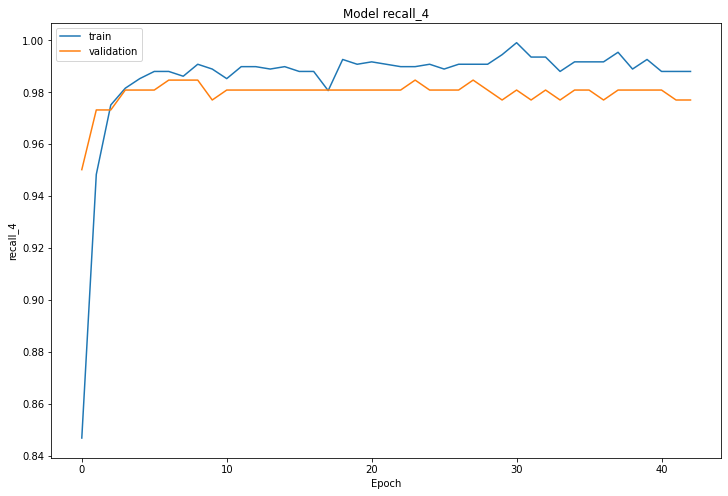

In [38]:
l = historyMi.history.keys()
print(l, len(l), type(l))
metrics = list(historyMi.history.keys())

df = pd.DataFrame(historyMi.history)

for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

# U-Net